To start, import all the modules we expect to use for cleaning, analysis, and visualization.

In [34]:
import pandas as pd
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import numpy as np
import itertools
import math
import random

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, Image

Next, import the dataset from the UCI archive and assign column names.

In [35]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"

names = ['BI-RADS','Age','Shape','Margin','Density','Severity'] # list of column names

mamm_df = pd.read_csv(url, sep = ",", names = names) # open as dataframe and assign column names 


Take a look at samples of the actual data.

In [36]:
print("First five lines: \n", mamm_df.head())

print("\nLast five lines: \n", mamm_df.tail())

display(mamm_df.dtypes)# check data types contained in dataframe

print("We can see that all columns except 'Severity' contain non-integers.")

First five lines: 
   BI-RADS Age Shape Margin Density  Severity
0       5  67     3      5       3         1
1       4  43     1      1       ?         1
2       5  58     4      5       3         1
3       4  28     1      1       3         0
4       5  74     1      5       ?         1

Last five lines: 
     BI-RADS Age Shape Margin Density  Severity
956       4  47     2      1       3         0
957       4  56     4      5       3         1
958       4  64     4      5       3         0
959       5  66     4      5       3         1
960       4  62     3      3       3         0


BI-RADS     object
Age         object
Shape       object
Margin      object
Density     object
Severity     int64
dtype: object

We can see that all columns except 'Severity' contain non-integers.


Turns out we have question marks in all columns. We need to convert these question marks in NaN (Not a Number) values in order to recognize them as mising values and handle them efficiently.

In [37]:
mamm_df = mamm_df.replace('?', np.nan)
display(mamm_df[19:25])


,BI-RADS,Age,Shape,Margin,Density,Severity
19,4,40,1,NaN,NaN,0
20,NaN,66,NaN,NaN,1,1
21,5,56,4,3,1,1
22,4,43,1,NaN,NaN,0
23,5,42,4,4,3,1
24,4,59,2,4,3,1


Now we can drop rows containing NaN values from our dataframe. 

In [38]:
mamm_df = mamm_df.dropna()
mamm_df = mamm_df.reset_index(drop=True)
mamm_df = mamm_df.apply(pd.to_numeric)

display(mamm_df[19:25])

,BI-RADS,Age,Shape,Margin,Density,Severity
19,5,54,4,4,3,1
20,5,57,4,4,3,1
21,4,39,1,1,2,0
22,4,81,1,1,3,0
23,4,60,2,1,3,0
24,5,67,3,4,2,1


Now that we have all numeric values, let's look at some summary statistics to get a better feel for our data.

In [39]:
display(mamm_df.describe())

,BI-RADS,Age,Shape,Margin,Density,Severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


We have an outlier in our BI-RADS column. 
The max value shows up as 55, but we know only goes from 0 to 6.
It seems likely this value was meant to be 5, but since we cannot be certain, let's drop this row as well.
Note that there are other ways to deal with missing data, but for our initial exploration, we'll simply exclude it.

In [43]:
print("max BI-RADS 55 is in row: ", mamm_df['BI-RADS'].idxmax())
display(mamm_df[250:260]) # show outlier


max BI-RADS 55 is in row:  257


,BI-RADS,Age,Shape,Margin,Density,Severity
250,5,54,4,5,3,1
251,5,55,4,3,3,1
252,4,64,4,4,3,0
253,5,67,4,5,3,1
254,5,75,4,3,3,1
255,5,87,4,4,3,1
256,4,46,4,4,3,1
257,55,46,4,3,3,1
258,5,61,1,1,3,1
259,4,44,1,4,3,0


In [45]:
mamm_df = mamm_df.drop(257,axis=0) # drop row
mamm_df = mamm_df.reset_index(drop=True) # reset index (row numbers)
display(mamm_df[250:260]) # check that outlier has been dropped and index reset
print("BI-RADS value counts:\n",mamm_df['BI-RADS'].value_counts()) # double check that the BI-RADS column 
# now contains only values 0 through 6

,BI-RADS,Age,Shape,Margin,Density,Severity
250,5,54,4,5,3,1
251,5,55,4,3,3,1
252,4,64,4,4,3,0
253,5,67,4,5,3,1
254,5,75,4,3,3,1
255,5,87,4,4,3,1
256,4,46,4,4,3,1
257,4,44,1,4,3,0
258,4,32,1,1,3,0
259,4,62,1,1,3,0


BI-RADS value counts:
 4    468
5    315
3     24
6      9
2      7
0      5
Name: BI-RADS, dtype: int64


Let's begin plotting our data and see if we can find anything interesting.

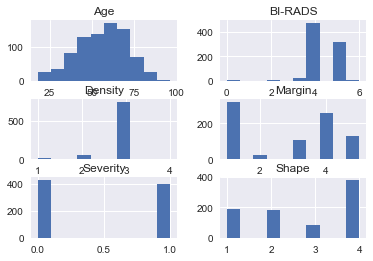

In [53]:
mamm_df.hist()
plt.show()

           BI-RADS       Age     Shape    Margin   Density  Severity
BI-RADS   1.000000  0.318936  0.410092  0.424551  0.056257  0.522909
Age       0.318936  1.000000  0.382328  0.421995  0.052529  0.456344
Shape     0.410092  0.382328  1.000000  0.737817  0.074241  0.567086
Margin    0.424551  0.421995  0.737817  1.000000  0.125273  0.576998
Density   0.056257  0.052529  0.074241  0.125273  1.000000  0.068145
Severity  0.522909  0.456344  0.567086  0.576998  0.068145  1.000000


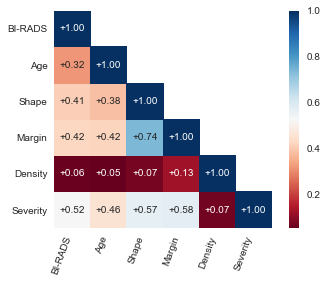

In [58]:
corr = mamm_df.corr()
print(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='+.2f')
    plt.xticks(rotation=70, ha='right')

#sns.pairplot(mamm_df, x_vars=['BI-RADS','Age','Shape','Margin','Density'], y_vars='Severity')

We can see some moderate correlations between Severity and Margin/Shape/BI-RADS on the heatmap above, but the strongest correlation is between Margin and Shape (+0.74). Strong correlations between features (not the target) can interfere with the success of regression-based models. Let's see if we can get anywhere with a Decision Tree first.

In [52]:
X = mamm_df.drop(['Age','Density','Severity'], axis=1) # features (input)
y = mamm_df.iloc[:,5] # labels (output)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (828, 3)
y shape:  (828,)


In [47]:
# set up X and y as train and test data for decision tree

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (621, 3)
y_train shape:  (621,)


In [48]:
scaler = StandardScaler().fit(X_train)
standardized_X = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

In [49]:
scaler = Normalizer().fit(X_train)
normalized_X = scaler.transform(X_train)
normalized_X_test = scaler.transform(X_test)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


Model Exploration

In [50]:
# train DecisionTreeClassifier

dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_pred = dtree_model.predict(X_test)

print(dtree_pred[:5])

[1 0 0 0 0]


In [51]:
# score accuracy

print("acc: ", accuracy_score(y_test, dtree_pred))

classification_report_noDA = classification_report(y_test, dtree_model.predict(X_test), labels=None)

print("report w/o density or age: \n", classification_report_noDA)

acc:  0.772946859903
report w/o density or age: 
              precision    recall  f1-score   support

          0       0.81      0.73      0.77       107
          1       0.74      0.82      0.78       100

avg / total       0.78      0.77      0.77       207

